In [1]:
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
sns.set()

#Load in FastTest module, custom module also used in the previous assignment. It is a backtesting framewok written
#in c++ and wrapped with pybind11, source code at https://github.com/ntorm1/Argus
sys.path.append(os.path.abspath('../lib'))
sys.path.append(os.path.abspath('..'))
import FastTest
from FastTest import PortfolioTracerType, ExchangeQueryType,OrderExecutionType
from Hal import Hal


#Question 1.
The momentum crashes paper is an extension of the classic momentum factor quantitative strategy that is used by many quantitative funds, mutual funds, and ETF's. The basics of a momentum strategy is to buy the winners and sell the losers, under the assumpetion that stocks, or any underlying asset, tend to trend in a direction. The paper notes that this type of strategy has been proven to beat buy and hold market strategies but is exposed to tail risk the authors call momentum crashes. 

These periods are in bear markets and the reasoning behind them is explained as the following: When the market falls over the fomration period of the momentum strategy, the momentum portfolio is likely to be long low beta stocks and short high beta stocks. As a result the portfolio beta will be largely negative and when the market rebounds the momentum strategy will crash. Further, the paper notes that in these situations the momentum portfolio is effectively short volaility during these periods.

Additionaly, the Authors show that these momentum crashs are predictable and that dynamically hedging the market beta of the portfolio does not improve the returns of the strategy. Instead, to maximize portfolio returns one should implement a strategy that maximizes the unconditional sharpe ratio of the portfolio by scaling the weights on the long-short strategy such that the volatility of the scaled strategy is proportional to the sharpe ratio of the strategy.  

In [2]:
#Question 2.
df = pd.read_csv("C:/Users/natha/Downloads/momentum.csv")
df["Effective date "] = pd.to_datetime(df["Effective date "])
df.set_index("Effective date ", inplace = True)
df.dropna(inplace = True)
df.columns = ["DJTMNMO","DJTMNMO_TR"]
df.tail()

,DJTMNMO,DJTMNMO_TR
Effective date,,
2020-05-05,1363.20,1443.13
2020-05-06,1372.54,1452.91
2020-05-07,1373.43,1454.12
2020-05-08,1355.27,1435.21
2020-05-11,1374.10,1454.99


In [3]:
#Download etf data and join into the existing data
data = yf.download(
            tickers = ["MOM", "MTUM", "SPY"],
            period = "10y",
            interval = "1d",
            group_by = 'ticker',
        )
data.columns = [' '.join(col).strip() for col in data.columns.values] 
data = data[[col for col in data.columns if "Adj" in col]]

df = pd.merge(df, data, left_index = True, right_index = True)
df

[*********************100%***********************]  3 of 3 completed


,DJTMNMO,DJTMNMO_TR,MOM Adj Close,SPY Adj Close,MTUM Adj Close
2013-05-17,1059.54,1066.64,23.799999,138.736893,47.023930
2013-05-20,1051.42,1058.48,23.760000,138.728592,46.962296
2013-05-21,1046.75,1053.82,24.286800,138.928070,47.164864
2013-05-22,1044.15,1051.20,24.224600,137.897507,46.909424
2013-05-23,1045.66,1052.82,24.258699,137.498642,46.803753
...,...,...,...,...,...
2020-05-05,1363.20,1443.13,29.392700,273.382599,115.208435
2020-05-06,1372.54,1452.91,29.174999,271.529388,115.179489
2020-05-07,1373.43,1454.12,29.318501,274.805878,116.008949
2020-05-08,1355.27,1435.21,29.309099,279.352905,117.330315


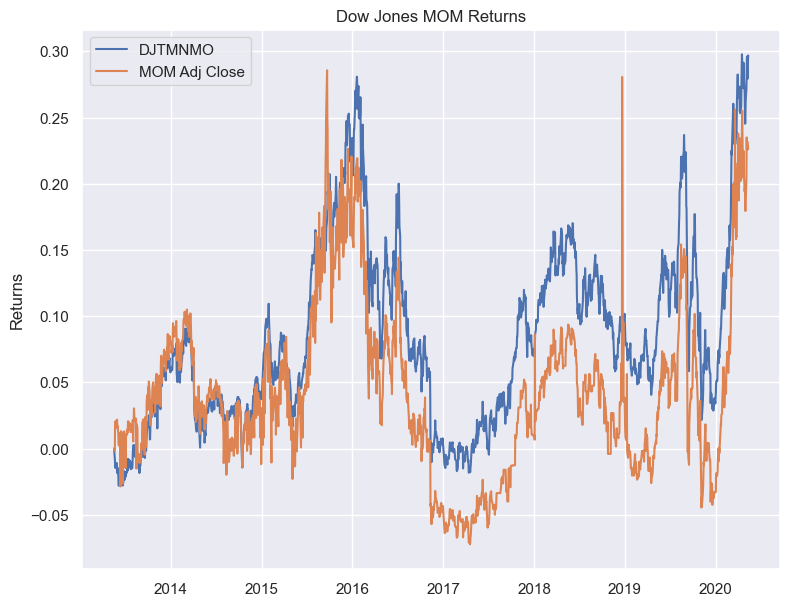

In [4]:
plt.figure(figsize=(9, 7))

for col in ["DJTMNMO", "MOM Adj Close"]:
    close = df[col].values
    returns = (close - close[0]) / close[0]
    plt.plot(df.index, returns, label = col)

plt.ylabel("Returns")
plt.title("Dow Jones MOM Returns")
_ = plt.legend()

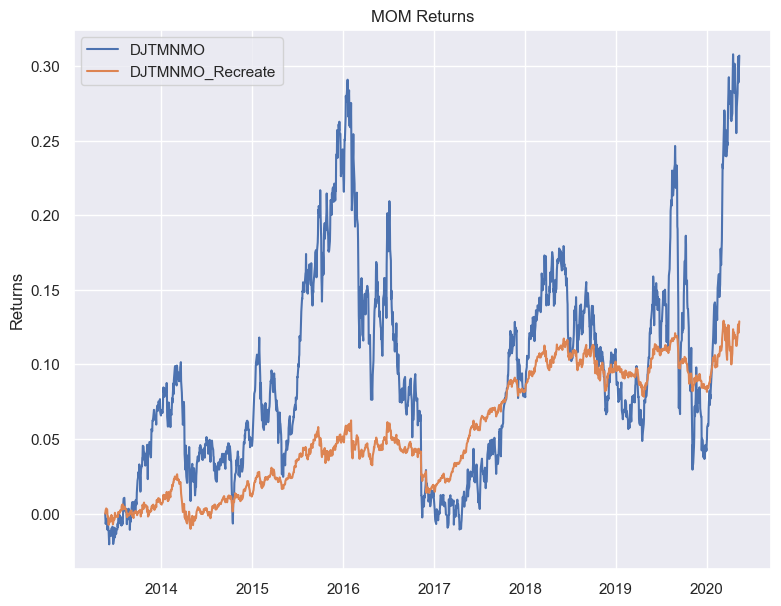

In [5]:
#Question 3
split = .5
daily_returns = df.pct_change()
daily_returns.columns = [col.split(" ")[0] for col in daily_returns.columns]
daily_returns["DJTMNMO_Recreate"] = split * daily_returns["MTUM"] - (1-split) * daily_returns["SPY"]
daily_returns.dropna(inplace = True)

daily_returns = (1+ daily_returns).cumprod()

plt.figure(figsize=(9, 7))

for col in ["DJTMNMO", "DJTMNMO_Recreate"]:
    close = daily_returns[col].values
    returns = (close - close[0]) / close[0]
    plt.plot(daily_returns.index, returns, label = col)

plt.ylabel("Returns")
plt.title("MOM Returns")
_ = plt.legend()

From the above graph we can see that using a portfolio 50% long MTUM and 50% short SPY get's as cumulative that are correlated with DJTMNMO, but have a different maginitude of variance. It is hard to replicate DJTMNMO exactly for two reasons.
1. DJTMNMO goes short the losers of the index, but with the data we are using and the question prompt, we only have MTUM and SPY, so the best we can do is go short the broad market index. This will reduce the variance of the returns of the recreated portfolio as shorting SPY as much lower variance in returns than shorting the indivual losers.
2. DJTMNMO aims to be market netural, i.e. have a beta equal to 0. However with the information we have we can not go beta netural. MTUM does not provide the beta of it's holdings so we cannot appropriately form market neutral portfolio without this information. Instead we go 50% short the market in our recreated portfolio.

The recreation does replicate the DJTMNMO price series to an extent. We see below that shorting SPY greatly increased the corrleation between DJTMNMO and the recreated DJTMNMO portfolio.

In [6]:
daily_returns.corr()

,DJTMNMO,DJTMNMO_TR,MOM,SPY,MTUM,DJTMNMO_Recreate
DJTMNMO,1.000000,0.985219,0.862568,0.315943,0.385572,0.585727
DJTMNMO_TR,0.985219,1.000000,0.787736,0.465872,0.529621,0.700271
MOM,0.862568,0.787736,1.000000,-0.095638,-0.021914,0.193683
SPY,0.315943,0.465872,-0.095638,1.000000,0.993807,0.903559
MTUM,0.385572,0.529621,-0.021914,0.993807,1.000000,0.942371
DJTMNMO_Recreate,0.585727,0.700271,0.193683,0.903559,0.942371,1.000000


In [7]:
#Question 4
#build a new backtest using the daily stock price data of the sp500. We load in the daily OHLC data for 
#every stock in the sp500 saved in the below folder
data_dir_path = r"C:\Users\natha\OneDrive\Desktop\C++\Argus\Argus\FastTest\tests\SP500_D"

hal = Hal(False, 100000)

exchange_id = "sp500_daily_exchange"
broker_id = "sp500_broker"

broker = hal.new_broker(broker_id,100000.0)
exchange = hal.new_exchange(exchange_id)

file_list = [os.path.join(data_dir_path, f) for f in os.listdir(data_dir_path) if os.path.isfile(os.path.join(data_dir_path, f))]
candles = 0
n = 120

time_min, time_max = 1e20, 0
for _file in file_list:
    _file_base = os.path.basename(_file)
    asset_id = os.path.splitext(_file_base)[0]
    
    df = pd.read_feather(_file)
    df["Date"] = df["Date"] * 1e9
    df.set_index("Date", inplace=True)
    
    #calculate rolling 1 month returns
    df["Returns"] = df["Close"].pct_change(n)
    df.dropna(inplace = True)
    
    if len(df) == 0:
        continue

    candles += len(df)
    hal.register_asset_from_df(df, asset_id, exchange_id, broker_id, warmup = 0) 

    if df.index.values[0] < time_min:
        time_min = df.index.values[0]
    if df.index.values[-1] > time_max:
        time_max = df.index.values[-1]

#Example of one asset loaded, OHLC data, returns, nanosecond epoch time index
df.tail()

,Adj Close,Close,High,Low,Open,Returns
Date,,,,,,
1.679011e+18,164.470001,164.470001,168.389999,163.649994,167.289993,0.091213
1.679270e+18,165.820007,165.820007,165.949997,163.699997,164.000000,0.110905
1.679357e+18,166.240005,166.240005,166.990005,165.139999,166.649994,0.107755
1.679443e+18,161.380005,161.380005,165.940002,161.320007,165.389999,0.055171
1.679530e+18,164.199997,164.199997,165.430893,162.070007,162.000000,0.082926


In [8]:
#create momentum crash signal defined as volatility exceeding 1.5 standard deviationas above the mean
path_spy = r"C:\Users\natha\OneDrive\Desktop\C++\Argus\Argus\FastTest\tests\data\SPY_DAILY.csv"
df_spy = pd.read_csv(path_spy)
df_spy["Date"] = pd.to_datetime(df_spy["Date"])
df_spy.set_index("Date", inplace = True)
df_spy.index = df_spy.index.astype('int64')

df_spy["Realized_Volatility"] = df_spy["Close"].pct_change().rolling(252).std()
df_spy["Realized_Volatility_Rol_Mean"] = df_spy["Realized_Volatility"].rolling(252).mean()
df_spy["Realized_Volatility_Rol_Std"] = df_spy["Realized_Volatility"].rolling(252).std()
df_spy["Realized_Volatility_Signal"] = (df_spy["Realized_Volatility"] > (df_spy["Realized_Volatility_Rol_Mean"] + \
                                        1.5 * df_spy["Realized_Volatility_Rol_Std"])).astype(float)
df_spy["Switch"] = (df_spy["Realized_Volatility_Signal"] > df_spy["Realized_Volatility_Signal"].shift(1)).astype(float)
df_spy.dropna(inplace = True)
df_spy.tail()


,Open,High,Low,Close,Adj Close,Volume,Realized_Volatility,Realized_Volatility_Rol_Mean,Realized_Volatility_Rol_Std,Realized_Volatility_Signal,Switch
Date,,,,,,,,,,,
1683676800000000000,413.880005,414.540009,408.869995,412.850006,412.850006,96142900,0.013788,0.013957,0.001274,0.0,0.0
1683763200000000000,411.950012,412.429993,409.970001,412.130005,412.130005,70157100,0.013787,0.013968,0.001259,0.0,0.0
1683849600000000000,413.420013,413.640015,409.070007,411.589996,411.589996,70439400,0.013750,0.013980,0.001243,0.0,0.0
1684108800000000000,412.220001,413.429993,410.230011,413.010010,413.010010,54210300,0.013751,0.013992,0.001227,0.0,0.0
1684195200000000000,411.859985,412.815002,410.709412,411.700012,411.700012,26431593,0.013672,0.014003,0.001211,0.0,0.0


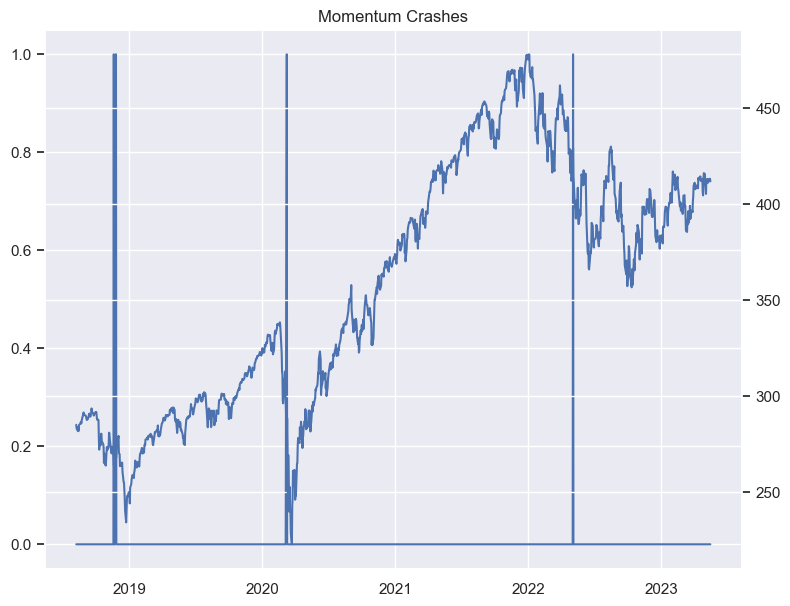

In [9]:
fig = plt.figure(figsize=(9,7))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

df_sub = df_spy.tail(1200)
df_sub.index = pd.to_datetime(df_sub.index)

ax.plot(df_sub["Switch"])
ax2.plot(df_sub["Close"])
_ = plt.title("Momentum Crashes")

The above signal is defined as the realized volatility being more than two standard deviations above the mean. We can use this signal to identify momentum crashes. When the signal crosses from 0 to 1, we should clear the portfolio and wait n periods to restart. This will prevent us from being short high beta stocks when markets rebound after a panic like in early 2020 after covid.

In [10]:
class MomentumStrategy:
    def __init__(self, hal : Hal) -> None:     
        self.hydra = hal.get_hydra()   
        self.exchange = hal.get_exchange(exchange_id)
        self.broker = hal.get_broker(broker_id)
        self.portfolio = hal.get_portfolio("master")
        self.counter = 0
            
        self.N_stocks = 10
        self.N_stocks_split = self.N_stocks // 2

    def build(self) -> None:
        return
                
    def on_open(self) -> None:
        return

    def on_close(self) -> None:
        #at momentum crash close all positions and wait
        current_time = self.hydra.get_hydra_time()
        momentum_crash = df_spy.loc[current_time,"Switch"]
        if momentum_crash:
            self.portfolio.order_target_allocations(
                {},                                             #dict of portfolio allocations
                "momentum_strategy",                            #strategy id
                .00,                                            #target epsilon
                order_execution_type = OrderExecutionType.EAGER #execute order allocations immediately 
            )
            self.counter = 1
            return
        #rebalance every n steps
        elif (self.counter % n) > 0:
            self.counter += 1
            return

        #Get value of given column for all assets listed on the exchange. In this case we want the 
        #lagged returns, sorted, and get the N largest, N Smallest
        exchange_features =  exchange.get_exchange_feature(
            "Returns",                                  #column to get
            query_type = ExchangeQueryType.NEXTREME,    #query type to use NEXTREME gets the N/2 largest and smallest
            N = self.N_stocks                           #number of assets to return
        )

        #allocate the portfolio by percentage of net liquidation value
        keys = list(exchange_features.keys())
        allocations_short= {asset_id : -1/self.N_stocks for asset_id in keys[0:self.N_stocks_split]}
        allocations_long = {asset_id : 1/self.N_stocks for asset_id in keys[self.N_stocks_split:]}
        allocations = {**allocations_long, **allocations_short}

        #use the target allocations dict to pass to the portfolio to generate orders so that the portfolio
        #matches the target allocations.
        self.portfolio.order_target_allocations(
            allocations,                                    #dict of portfolio allocations
            "momentum_strategy",                            #strategy id
            .00,                                            #target epsilon
            order_execution_type = OrderExecutionType.LAZT  #execute order allocations with lazy execution 
        )
        self.counter += 1


In [11]:
#run the strategy 
strategy = MomentumStrategy(hal)
hal.register_strategy(strategy, "momentum_strategy") 
hal.build()
st = time.time()
hal.reset()
hal.run()
et = time.time()

mp = hal.get_portfolio("master")
nlv = mp.get_tracer(PortfolioTracerType.VALUE).get_nlv_history()
    
print(f"FastTest completed in {et-st:.6f} seconds")
print(f"FastTest Final Portfolio Value: {nlv[-1]:,.4f}")
print(f"HAL: candles per second: {(candles / (et-st)):,.3f}")

FastTest completed in 0.032559 seconds
FastTest Final Portfolio Value: 153,376.1072
HAL: candles per seoncd: 17,369,035.421


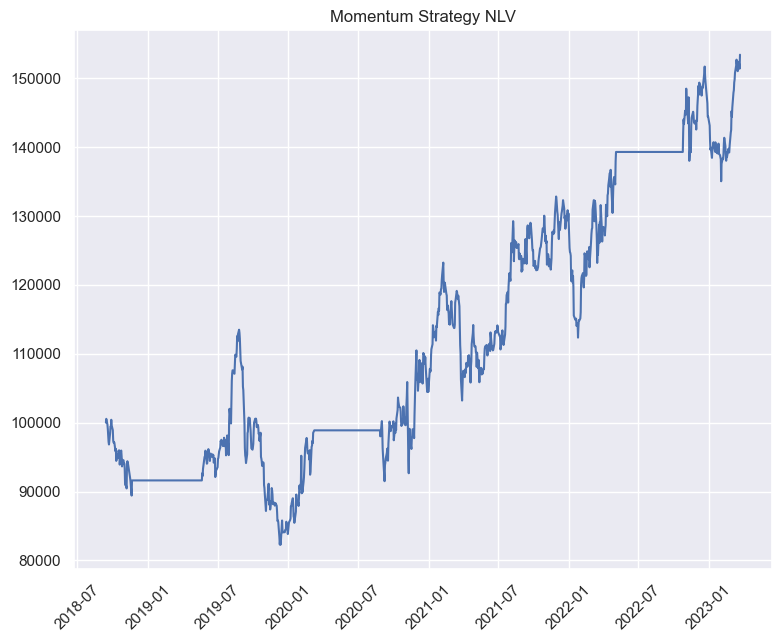

In [12]:
#Lets take a look at how the strategy did

df = hal.get_value_history()

plt.figure(figsize=(9, 7))
plt.title("Momentum Strategy NLV")
plt.plot(df["NLV"])
_ = plt.xticks(rotation=45)

We see from the above plot that our strategy benefits from shutting down when volatility exceeds 1.5 standard deviations above the mean. By doing this, we prevent out momentum strategy from suffering the crashes described in the paper when stocks rebound after a dip. 

To improve this strategy we could scale the positions by their respective beta, right now each stock is allocated the same pct of the portfolio, but it coulld change such that the are allocated the same beta dollar size.

Question 5)
To estimate the trade volume of people who track the momentum factor I would look at the descrpencies between MOM etf and the DJTMNMO index that it tracks. It seems as though the greater the descrepency between the two, the greater the volume of trades tracking the momentum factor.

This would be result of the fact that if more people are tracking the momentu factor than the spreads on the trades will tighten and the alpha will fall. As a result the ETF will have a harder time entering and exiting positions and as a result lag behing the index by an increasing large margin.

Additionally I would look at the realized volatility relative to it's mean like we did above generating the switch signal. It seems as though lower realized volatility, i.e. sideways or trending up markets lend themselves more to momentum trading so the trade volume tracking this factor will increase. 

We could also look at the bid ask spreads of the winners and losers and try and see if they are tighter tan we expect. Without people tracking the momentum factor we might expect them to differ from the mean bid ask spread as a percentage of the price, but if more people are trading the momentum factor then those spreads will be tighter than they might otherwise be.